In [17]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.regularizers import l2, activity_l2
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import scipy.misc
import random
import numpy as np
import time
import cv2
import pickle
from sklearn.utils import shuffle

In [18]:
driving_log=pd.read_csv('../data/trimmed_driving_log.csv').sample(frac=1.0)

driving_log.describe()

,steering
count,4046.000000
mean,0.008083
std,0.181498
min,-0.942695
25%,-0.088240
50%,0.000000
75%,0.128740
max,1.000000


In [19]:
f = open('../gallery.p', 'rb')   
gallery = pickle.load(f)      
f.close() 
print(len(gallery))

24108


In [20]:
def augment_brightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    image[:,:,2] = image[:,:,2]*random_bright
    return image

def trans_image(image,steer,trans_range=50, trans_y=False):
    """
    translate image and compensate for the translation on the steering angle
    """
    assert(image is not None)
    rows, cols, chan = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*.4
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40*np.random.uniform()-40/2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

pts1 = np.float32([[140,60],[180,60],[0,100],[320,100]])
pts2 = np.float32([[140,0],[180,0],[0,120],[320,120]])

M = cv2.getPerspectiveTransform(pts1,pts2)

def transform(img):
    dst = cv2.warpPerspective(img,M,(320,160))
    dst = cv2.resize(dst, (64,64))
    return dst / 255 - 0.5

In [21]:
y_train_log = []
def generate_batch_samples(df, batch_size=128):    
    camera_shift_rate = {0:0, 1:0.27, 2:-0.27}
    while 1:
        df = df.sample(batch_size)
        source_arr = df.as_matrix()
        
        batch_x, batch_y = [], []
        for row in source_arr:
            # randomly pick between left right and center camaras
            rnd = random.randint(0,2)
            
            image = gallery[row[rnd].strip()]
            
            # compensate -0.2 for right camera and 0.2 for left camera 
            angle = row[3] + camera_shift_rate[rnd] 
            angle = max(-1, angle)
            angle = min(1, angle)
            
            # horizontally random shift the image
            image, angle = trans_image(image, angle)
            
            # brightness augmentation
            if random.random() >0.5:
                image = augment_brightness(image)
                
            #randomly flip
            if random.random() >0.5:
                image = cv2.flip(image, 0)
                angle = -angle
            
            batch_x.append(transform(image))
            batch_y.append(angle)
            y_train_log.append(angle)
        yield shuffle(np.array(batch_x), np.array(batch_y))
                
    
y_valid_log = []
def generate_batch_valid(df, batch_size=128):
    while 1:
        df = df[['center','steering']].sample(batch_size)
        source_arr = df.as_matrix()
        
        batch_x, batch_y = [], []
        for row in source_arr:
            image = gallery[row[0].strip()]
            angle = row[1]
            
            batch_x.append(transform(image))
            batch_y.append(angle)
            y_valid_log.append(angle)
        yield shuffle(np.array(batch_x), np.array(batch_y))
            

In [22]:
def getVGG16model(input_shape=(64,64,3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    prediction = Dense(1, name='prediction')(x)

    model = Model(input=base_model.input, output=prediction)

    optimizer = Adam()
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [23]:
def get_commaai_model(input_shape=(64,64,3)):
    model = Sequential()
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same",input_shape=input_shape))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

In [24]:
def nvidia_model(input_shape=(64,64,3)):
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT,input_shape=input_shape, W_regularizer=l2(reg_val)))
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model


In [25]:
from keras.callbacks import EarlyStopping
epochs = 20
batch_size = 450

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [26]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(driving_log, train_size=0.85)

train_gen = generate_batch_samples(df_train, batch_size=batch_size)
valid_gen = generate_batch_valid(df_valid, batch_size=batch_size)

In [27]:
model = getVGG16model(input_shape=(64,64,3))
#model = nvidia_model()
#model = get_commaai_model()
print(model.summary())
# train model with generator
model.fit_generator(
    train_gen,
    samples_per_epoch=batch_size*30, nb_epoch=epochs,
    validation_data=valid_gen,
    nb_val_samples=batch_size,
    callbacks=[early_stopping]
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 64, 64)    1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 64, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 32, 32, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [28]:
model.save('../model.h5')

In [29]:
### performance review

In [30]:
from keras.models import load_model
model = load_model('../model.h5')

real steering angle -0.5249807, predicted -0.1686197966337204


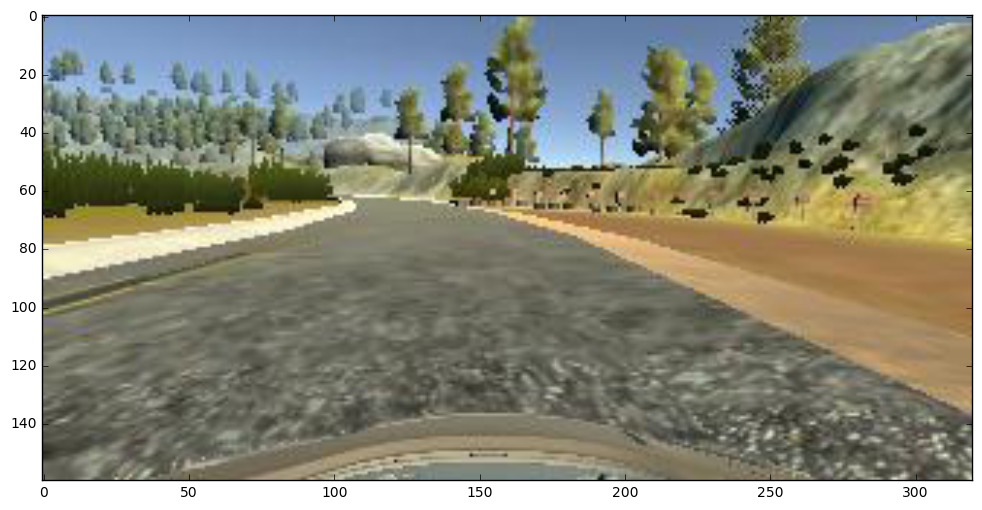

real steering angle 0, predicted -0.11524152010679245


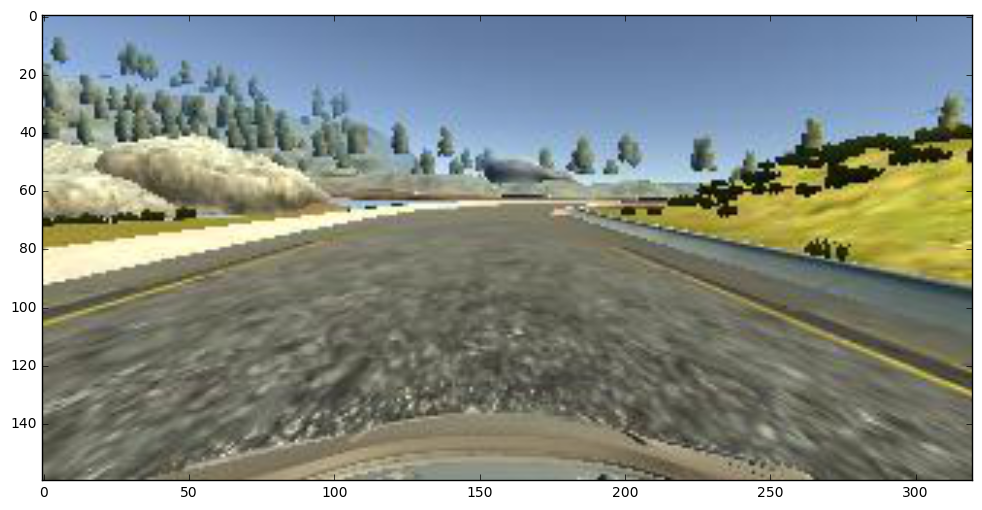

real steering angle 0.3009732, predicted 0.21396584808826447


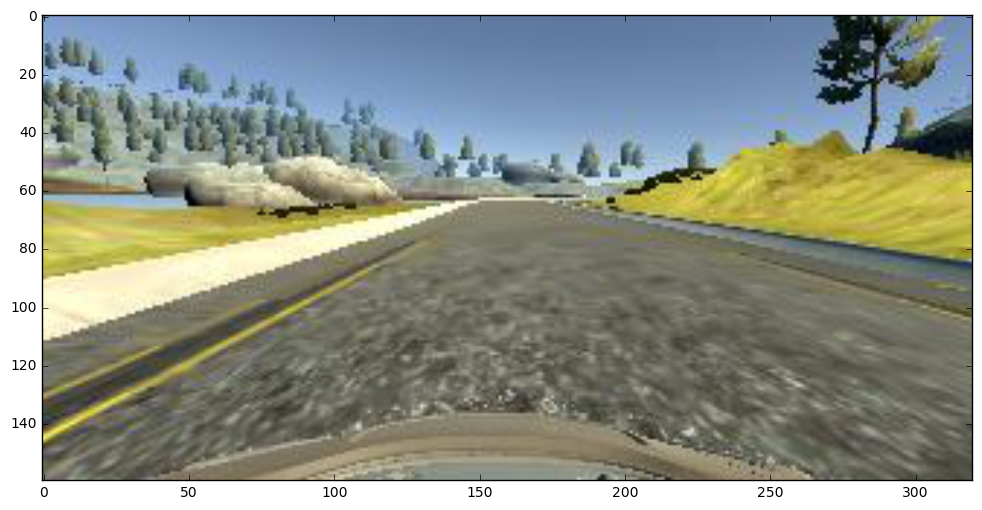

In [31]:
import cv2
import matplotlib.pyplot as plt

pts1 = np.float32([[140,60],[180,60],[0,100],[320,100]])
pts2 = np.float32([[140,0],[180,0],[0,120],[320,120]])

M = cv2.getPerspectiveTransform(pts1,pts2)

def transform(img):
    dst = cv2.warpPerspective(img,M,(320,160))
    dst = cv2.resize(dst, (64,64))
    return dst

X_test = ['../data/IMG/center_2016_12_01_13_45_23_127.jpg'
          ,'../data/IMG/center_2016_12_01_13_46_37_916.jpg'
          ,'../data/IMG/center_2016_12_01_13_46_27_362.jpg']
Y_test = [-0.5249807, 0, 0.3009732]
for x, y in zip(X_test,Y_test):
    img = scipy.misc.imread(x)
    image_array = transform(np.asarray(img)) / 255 -0.5
    steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
    print('real steering angle {}, predicted {}'.format(y, steering_angle))
    plt.imshow(img)
    plt.show()

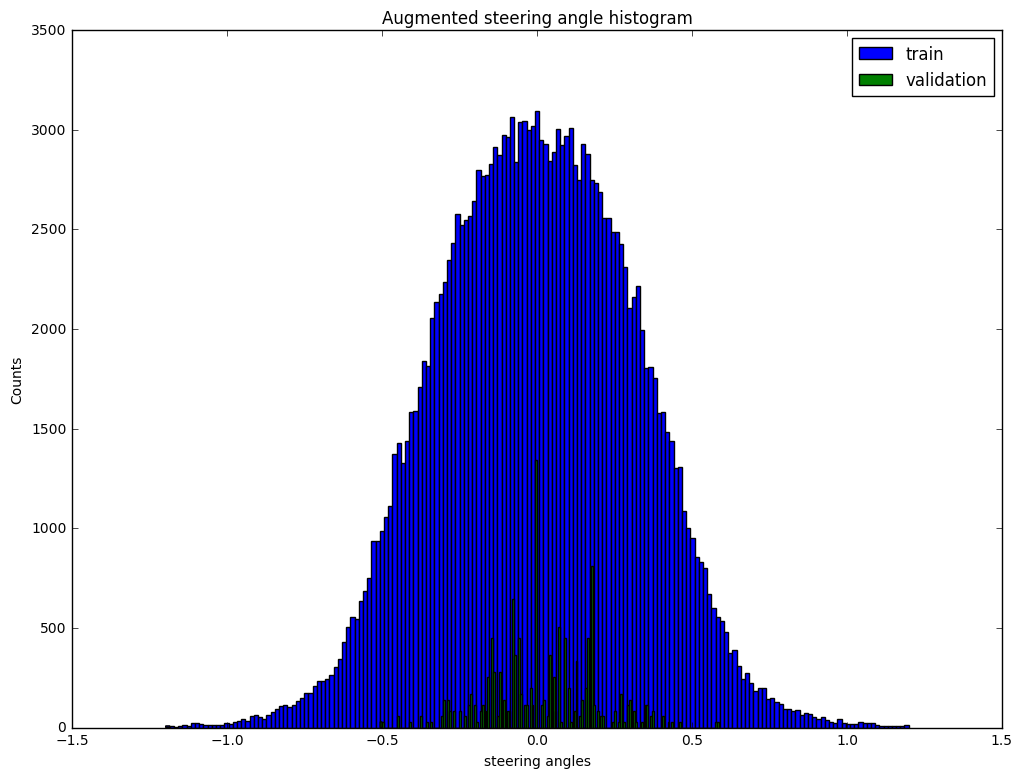

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
def inspectHistogram():
    pltChangeSize()
    
    plt.hist(y_train_log, bins=177, label='train')
    plt.hist(y_valid_log, bins=177, label='validation')

    plt.title('Augmented steering angle histogram')  
    plt.xlabel('steering angles')  
    plt.ylabel('Counts')  
    plt.legend()  

def pltChangeSize():
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width to 12 and height to 9
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size

inspectHistogram()